# Customer Segmentation using K-Means Clustering
This notebook walks through the analysis to divide customers into groups/segments using K-Means clustering. K-means clustering is an unsupervised classification method that clusters data by trying to separate samples in n groups of equal variance.

Because there are over 49,500 products in the database, clustering was performed using the `aisle` attribute. `Aisle` represents product categories and there are 134 unique aisles in the dataset. In addition, Principal Component Analysis (PCA) was performed to further reduce the number of dimensions used to train the model. Number of principal components was chosen such that 95% of variance is retained.

Number of clusters was selected by reviewing metrics including inertia, Silhouette coefficient and Calinski-Harabaz score

Two alternatives were done:

1) Segmentation using provided `aisle` attribute

2) Segmentation by adding the organic-related labels to the `aisle` attribute. For example, 'Organic Clementines' was reassigned to 'organic packaged vegetables fruits' `aisle` from 'organic packaged vegetables fruits'

## Import Data
1) Import Instacart data from PostgreSQL

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt

# postgres login credentials and DB location
from config import pg_user, pg_pw
db_loc = 'localhost:5432'
db_name = 'p3_instacart'
engine = create_engine(f"postgresql+psycopg2://{pg_user}:{pg_pw}@{db_loc}/{db_name}")
connection = engine.connect()

In [2]:
aisles = pd.read_sql("SELECT * FROM aisles", connection)
departments = pd.read_sql("SELECT * FROM departments", connection)
products = pd.read_sql("SELECT * FROM products", connection)
orders = pd.read_sql("SELECT * FROM orders", connection)
order_products = pd.read_sql("SELECT * FROM order_products", connection)

2) Generate order history table by joining the different tables from database

In [7]:
# Joining products with aisle and department
products_merge = products.merge(aisles, how='left', on='aisle_id').merge(departments, how='left', on='department_id')
products_merge.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [8]:
# Joining orders with order_products and products_merge
orders_history = orders.merge(order_products, on='order_id').merge(products_merge, on='product_id').sort_values(by='order_id')

# Example for `Order_id` = 1
orders_history[orders_history['order_id']==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
23218323,1,112108,train,4,4,10,9.0,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
13576120,1,112108,train,4,4,10,9.0,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
32575950,1,112108,train,4,4,10,9.0,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
4129259,1,112108,train,4,4,10,9.0,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
2346045,1,112108,train,4,4,10,9.0,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce
281612,1,112108,train,4,4,10,9.0,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce
32723104,1,112108,train,4,4,10,9.0,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4262054,1,112108,train,4,4,10,9.0,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs


`Order_ID` 1
- Bought by `user_id` 112108
- Has 8 items, half of them were first-time order
- Items include organic vegetables and cheese

## Group Orders by User ID and Aisle
To divide customers into groups based on `aisle`/product category, first add up the purchases by `aisle` for each `user_id`

In [12]:
orders_user_aisle = pd.crosstab(index=orders_history['user_id'], columns=orders_history['aisle'])
# show User ID 1 to 20
orders_user_aisle.head(20)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,3,0,28


There are 134 aisles/product categories

#### Add a new column to count total number of items purchased by each customer

In [13]:
orders_user_aisle['Total'] = orders_user_aisle.sum(axis=1)
orders_user_aisle.head(3)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,70
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,226
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,88


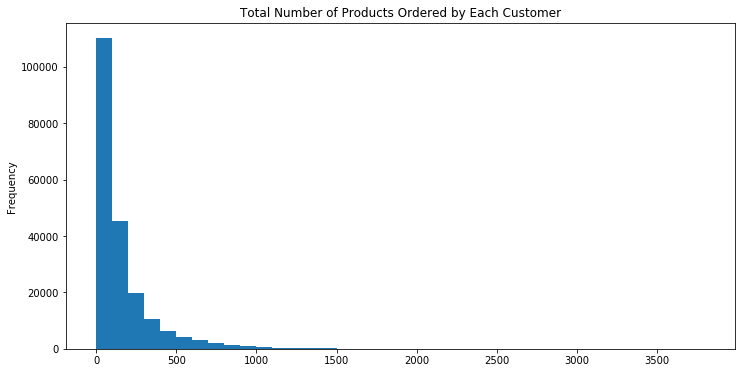

In [88]:
# Plot histogram for total # of products by customer
plt.figure()
plt.rcParams["figure.figsize"] = (12,6)
orders_user_aisle['Total'].plot(kind='hist', bins=range(0,max(orders_user_aisle['Total'])+100, 100))
plt.title('Total Number of Products Ordered by Each Customer')
plt.show()

In [17]:
orders_user_aisle['Total'].describe()

count    206209.000000
mean        164.004025
std         206.014923
min           3.000000
25%          44.000000
50%          90.000000
75%         196.000000
max        3725.000000
Name: Total, dtype: float64

## Create Training Set
- There are 206,209 unique customers in the dataset, majority of them bought less than 100 items
- Randomly select approximately 20,000 customers with over 100 ordered items as training set

In [23]:
print(f'There are {len(orders["user_id"].unique()):,} users in orders table. {len(orders_user_aisle[orders_user_aisle["Total"] >= 100]):,} of them ordered more than 100 items')

There are 206,209 users in orders table. 96,040 of them ordered more than 100 items


In [24]:
# use sklearn train_test_split module to select 
from sklearn.model_selection import train_test_split
Cust_train, Cust_test = train_test_split(orders_user_aisle[orders_user_aisle['Total'] >= 100], train_size=0.21, random_state=42)
Cust_train

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,4,0,9,227
147319,0,1,0,0,0,1,1,2,0,0,...,0,1,2,0,0,0,0,0,1,103
85028,0,8,0,3,126,0,1,0,0,0,...,0,0,1,0,0,0,0,0,33,731
72168,0,0,0,0,0,0,4,0,0,0,...,7,0,1,0,0,0,6,0,3,185
142535,0,1,0,0,0,0,1,0,0,0,...,1,0,2,0,1,0,9,0,0,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,0,0,0,0,19,0,1,0,0,0,...,0,0,11,0,0,0,0,0,43,986
117498,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,110
164881,0,1,0,0,0,0,6,0,0,0,...,0,0,0,1,0,0,1,0,10,118


In [25]:
print(f'The training set includes {len(Cust_train):,} customers')

The training set includes 20,168 customers


## Dimension Reduction - Principal Component Analysis
Principal Component Analysis (PCA) was performed to reduce the number of dimensions to reduce model runtime while retaining 95% of the explained varaince.

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [87]:
scaler = RobustScaler()
cust_train_rescaled = scaler.fit_transform(Cust_train)
df_cust_train_rs = pd.DataFrame(cust_train_rescaled)
df_cust_train_rs.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.250,0.0,0.200000,0.073394
1,0.0,0.5,0.0,0.0,0.0,1.0,0.00,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,-0.250,0.0,-0.333333,-0.495413
2,0.0,4.0,0.0,3.0,126.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,-0.250,0.0,1.800000,2.385321
3,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,...,3.5,0.0,0.5,0.0,0.0,0.0,0.500,0.0,-0.200000,-0.119266
4,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.5,0.0,1.0,0.0,1.0,0.0,0.875,0.0,-0.400000,-0.481651


#### Plot variance by number of principal components
95% of the variance can be explained by less than 80 `aisle`/product categories

<Figure size 864x432 with 0 Axes>

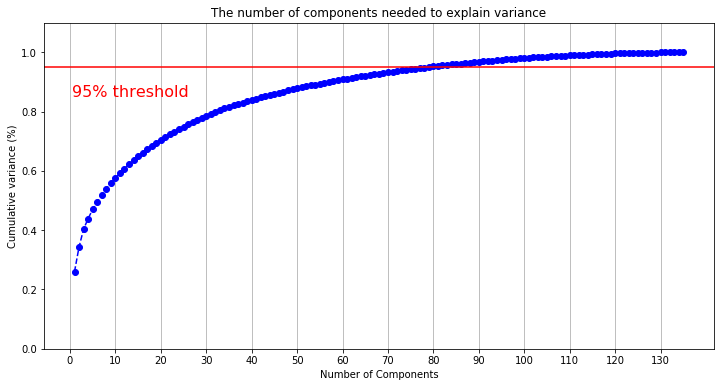

In [89]:
model = PCA().fit(cust_train_rescaled)

plt.figure()
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 136, step=1)
y = np.cumsum(model.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 140, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#### Examining which `aisle`/product category are the most importnant/critical

In [104]:
model.explained_variance_ratio_

array([2.59921057e-01, 8.37243621e-02, 5.99455698e-02, 3.58397331e-02,
       3.06140335e-02, 2.61327492e-02, 2.30401567e-02, 2.10264204e-02,
       1.91005758e-02, 1.65899798e-02, 1.62504702e-02, 1.55787661e-02,
       1.47216408e-02, 1.39615931e-02, 1.27176950e-02, 1.25721171e-02,
       1.15058683e-02, 1.10642095e-02, 1.04325524e-02, 9.91650870e-03,
       9.44093461e-03, 9.21239809e-03, 8.98431188e-03, 8.75474973e-03,
       8.41047839e-03, 8.14385368e-03, 7.67430078e-03, 7.61791481e-03,
       7.01384605e-03, 6.59337499e-03, 6.53215779e-03, 6.18626608e-03,
       5.84294093e-03, 5.52241754e-03, 5.25901322e-03, 5.00724561e-03,
       4.80974692e-03, 4.62528225e-03, 4.53341888e-03, 4.43691137e-03,
       4.39683401e-03, 4.25730155e-03, 4.21720118e-03, 4.00981130e-03,
       3.98931190e-03, 3.81623760e-03, 3.67643387e-03, 3.61707790e-03,
       3.49891487e-03, 3.41315748e-03, 3.40358557e-03, 3.29496974e-03,
       3.16108261e-03, 3.13105079e-03, 3.04723858e-03, 3.00947017e-03,
      

In [99]:
model.components_[0]

array([-6.41520049e-04,  6.04125051e-03,  7.44051443e-03,  4.57589773e-03,
        9.90868293e-01,  2.83571543e-03,  7.85525162e-03,  1.84686931e-03,
        6.25633502e-04, -4.18964808e-03, -1.17142781e-04,  1.29803230e-02,
        1.79613213e-02,  8.26140260e-03,  2.94099795e-03,  2.21556932e-03,
        1.07091622e-02,  9.72108488e-03,  1.09705611e-02,  2.65723141e-02,
        1.28208751e-02,  1.20032118e-02,  3.68010816e-03, -1.20752521e-03,
        1.19149083e-02,  8.67849093e-03,  9.81732314e-03, -9.08695546e-04,
        1.60610754e-02,  2.30665971e-03,  6.21882616e-03,  1.17308700e-02,
        1.83013666e-02,  6.91988728e-03,  6.03875584e-04,  1.45214629e-02,
        2.53666540e-03,  1.74702681e-02, -4.65739620e-04,  1.44535038e-02,
        1.42341569e-02,  9.99256395e-03,  1.74103394e-02,  3.64615680e-03,
        1.42555554e-04,  9.44290015e-05,  1.54987407e-03,  1.63168979e-04,
        3.84594492e-03,  1.21968236e-02,  1.97579547e-02,  7.00016728e-03,
        7.19942866e-03,  

In [92]:
# number of components
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = orders_user_aisle.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
# build the dataframe
df = pd.DataFrame(dic.items())
df
# df.to_csv('pca.csv')

,0,1
0,PC0,baby food formula
1,PC1,packaged produce
2,PC2,coffee
3,PC3,cat food care
4,PC4,coffee
...,...,...
130,PC130,baby bath body care
131,PC131,kitchen supplies
132,PC132,eye ear care
133,PC133,beauty


In [103]:
df.iloc[:,1].value_counts()

seafood counter               3
energy sports drinks          3
specialty wines champagnes    2
protein meal replacements     2
tea                           2
                             ..
cream                         1
doughs gelatins bake mixes    1
eye ear care                  1
dog food care                 1
muscles joints pain relief    1
Name: 1, Length: 112, dtype: int64

## Run PCA by setting the number of principal components to explain 95% of variance

In [94]:
cust_train_reduced = PCA(n_components = 0.95).fit_transform(cust_train_rescaled)
cust_train_reduced.shape

(20168, 79)

In [19]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabaz_score

def kmeans_metrics(data, k):
    '''
        Compute K-Means partitions for various values of K, ranging from 
        2 to k+1.  Caclucate the inertia, silhouette score, and calinkski-harabaz
        score for each value of k, returning the results.
        
        Params
        ------
        data: The dataset to perform KMeans clustering
        
        k: The number of partitions to create
    '''
    
    # create an array to hold our results
    inertias = []
    silhouette_scores = []
    calinski_score = []
    
    # Process each range
    for i in range(2, k+1):
        print('processing k={}'.format(i))
        
        # build model
        model = KMeans(n_clusters=i, init='k-means++',random_state=42).fit(data)
        
        # determine scores
        inertias.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, model.labels_))
        calinski_score.append(calinski_harabaz_score(data, model.labels_))
    
    return inertias, silhouette_scores, calinski_score

In [20]:
clusters = 20
# find the inertias related to each cluster size
inertias, silhouette_scores, calinski_score = kmeans_metrics(reduced, clusters)

processing k=2


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=3


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=4


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=5


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=6


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=7


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=8


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=9


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=10


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=11


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=12


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=13


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=14


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=15


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=16


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=17


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=18


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=19


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


processing k=20


C:\Users\chanwc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


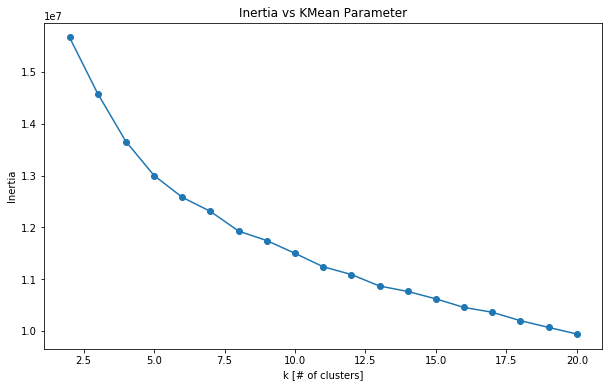

In [21]:
# Plot our results for inertia vs cluster size
fig, ax = plt.subplots(figsize=(10,6))

# plot results
plt.plot(np.arange(2, clusters+1), inertias, 'o-')

# set labels
plt.xlabel('k [# of clusters]')
plt.ylabel('Inertia')
plt.title('Inertia vs KMean Parameter')

# plt.savefig('../reports/figures/kmeans_inertia.png')

plt.show()

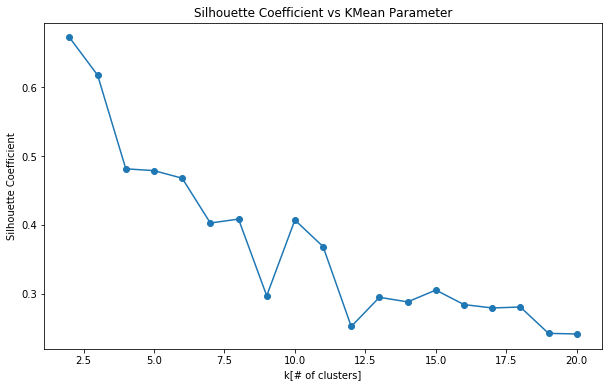

In [22]:
# plot silhouette vs cluster size 
fig, ax = plt.subplots(figsize=(10,6))

# plot silhouette_scores
plt.plot(np.arange(2, clusters+1), silhouette_scores, 'o-')

# set label
plt.ylabel('Silhouette Coefficient')
plt.xlabel('k[# of clusters]')
plt.title('Silhouette Coefficient vs KMean Parameter')

# save
# plt.savefig('../reports/figures/kmeans_silhouette_coefficient.png')

plt.show()

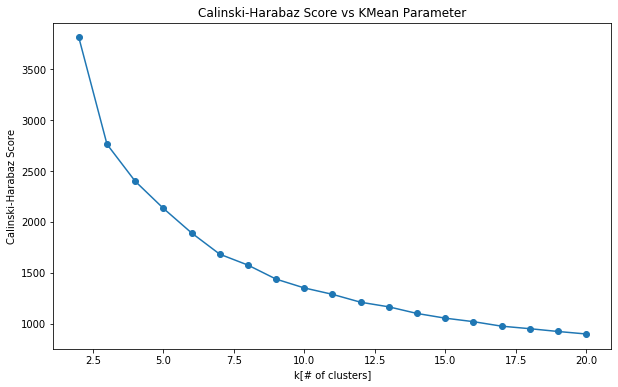

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

# plot calinski_score
plt.plot(np.arange(2, clusters+1), calinski_score,'o-')

# set label
plt.ylabel('Calinski-Harabaz Score')
plt.xlabel('k[# of clusters]')
plt.title('Calinski-Harabaz Score vs KMean Parameter')

# save
# plt.savefig('../reports/figures/kmeans_calinski_harabaz_score.png')

plt.show()

In [44]:
pd.DataFrame(reduced)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-2.878050,-1.680572,-0.291981,2.851453,2.299242,11.178002,-6.145324,2.542159,-0.879571,-5.265255,...,-0.110406,0.746458,-0.126322,0.308226,0.012021,-0.446563,-0.659447,-0.345035,0.101216,-0.973130
1,3.667230,-5.604276,0.158310,-8.913235,13.237846,-4.616524,3.530555,-0.515357,-0.161491,-1.295749,...,-0.877372,0.051363,-2.084168,0.409118,-1.632381,0.852111,0.625025,-0.315934,-0.263901,0.347568
2,-5.564465,1.721454,1.255403,-0.855524,-0.820494,-0.078275,0.565138,-0.077806,-0.262908,0.668902,...,-0.081018,-0.154994,-0.233467,-0.013543,-0.366783,-0.540471,-0.370500,0.097349,0.197130,-0.158768
3,-7.353458,2.418036,1.545108,-2.249705,2.442632,0.587187,0.321137,-0.264370,0.173516,-0.117471,...,0.021311,0.288546,-0.220553,0.583389,-0.056214,-0.018659,0.521838,0.780978,0.199141,0.087304
4,-7.481900,2.663775,2.036041,-1.012224,-0.526826,-0.035699,0.426885,0.067778,-0.007168,-0.219414,...,-0.260722,-0.240003,-0.101311,-0.014296,0.094815,-0.100629,-0.094390,0.106336,-0.112094,0.022834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,-6.952954,2.352918,1.818507,0.821839,0.281844,-0.357463,0.507291,-0.707494,1.274239,0.461052,...,-0.057917,0.147554,-0.298675,-0.004854,-0.008448,0.121115,0.058856,-0.099986,0.046134,-0.322648
206205,11.160169,-10.661909,-3.843233,0.174755,-0.683113,4.781008,-0.353195,1.447339,1.849125,-2.324729,...,-0.916779,0.526481,1.384184,-0.112849,0.191143,-0.019102,2.109608,3.174992,-0.631795,-0.520803
206206,1.951346,-2.272105,2.401021,-1.202747,-3.581759,-3.543790,-0.091377,-1.214852,-2.711183,-1.714938,...,-0.459546,-0.056655,-1.301937,-0.078528,1.155576,0.325086,2.160653,-1.800092,0.530183,0.408266
206207,29.997337,-20.428701,10.623999,0.416199,-10.155172,-16.223868,-6.730368,0.796470,10.184529,-5.688829,...,7.349126,-0.564357,-0.616910,0.015813,2.658626,-1.207034,4.280901,0.419848,-1.884596,-2.124035


In [24]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=4, random_state=42).fit(reduced)
c_pred = kmeans_model.predict(reduced)

# print our the number of observations per cluster
for c in np.unique(c_pred):
        print('cluster {}: {}'.format(c, np.sum(c_pred==c)))

cluster 0: 18027
cluster 1: 140
cluster 2: 216
cluster 3: 825


In [35]:
# add the predicticed cluster to our original dataframe
kmeans_cluster = X_train.iloc[:, :-1].copy()
kmeans_cluster['cluster'] = c_pred

# print our the number of observations per cluster
for c in np.unique(kmeans_cluster.cluster):
        print('cluster {}: {}'.format(c, np.sum(kmeans_cluster.cluster==c)))

cluster 0: 18027
cluster 1: 140
cluster 2: 216
cluster 3: 825


In [36]:
kmeans_cluster.groupby('cluster').mean()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.174793,1.513618,0.063072,0.061241,1.040328,0.292339,2.853830,0.187386,0.048871,0.349975,...,2.509347,2.319521,1.196483,1.719865,0.264825,0.255395,0.389028,7.142231,0.237200,12.925168
1,0.121429,2.742857,1.200000,0.485714,141.242857,0.571429,6.121429,0.521429,0.100000,0.042857,...,6.321429,5.778571,3.107143,4.500000,0.700000,0.664286,1.892857,15.814286,0.014286,42.142857
2,0.004630,0.203704,0.000000,0.000000,0.000000,0.361111,1.314815,0.240741,0.009259,0.166667,...,2.287037,1.550926,0.101852,0.393519,2.009259,0.222222,0.041667,7.037037,0.064815,7.143519
3,0.077576,2.086061,0.335758,0.351515,41.667879,0.298182,4.210909,0.178182,0.077576,0.027879,...,4.481212,2.693333,2.166061,3.298182,0.320000,0.289697,0.640000,10.242424,0.063030,28.827879


In [37]:
top_aisle_per = kmeans_cluster[kmeans_cluster.cluster==0].mean() / kmeans_cluster[kmeans_cluster.cluster==0].mean().sum()
top_aisle_per.sort_values(ascending=False)[:12]

aisle
fresh fruits                     0.113203
fresh vegetables                 0.111287
packaged vegetables fruits       0.055692
yogurt                           0.045992
packaged cheese                  0.030313
milk                             0.026900
water seltzer sparkling water    0.025414
chips pretzels                   0.023020
soy lactosefree                  0.019931
bread                            0.018324
refrigerated                     0.018011
frozen produce                   0.016038
dtype: float64

In [38]:
top_aisle_per = kmeans_cluster[kmeans_cluster.cluster==1].mean() / kmeans_cluster[kmeans_cluster.cluster==0].mean().sum()
top_aisle_per.sort_values(ascending=False)[:12]

aisle
baby food formula                0.502584
fresh fruits                     0.360812
fresh vegetables                 0.272185
packaged vegetables fruits       0.153337
yogurt                           0.149957
packaged cheese                  0.096633
milk                             0.093609
water seltzer sparkling water    0.056272
bread                            0.052765
frozen produce                   0.052536
soy lactosefree                  0.052510
crackers                         0.052155
dtype: float64

In [39]:
top_aisle_per = kmeans_cluster[kmeans_cluster.cluster==2].mean() / kmeans_cluster[kmeans_cluster.cluster==0].mean().sum()
top_aisle_per.sort_values(ascending=False)[:12]

aisle
packaged produce                 0.256544
fresh fruits                     0.193235
packaged vegetables fruits       0.063671
fresh vegetables                 0.050475
milk                             0.031992
yogurt                           0.025419
water seltzer sparkling water    0.025040
packaged cheese                  0.023129
chips pretzels                   0.021185
cereal                           0.021020
soft drinks                      0.020361
bread                            0.016556
dtype: float64

In [40]:
top_aisle_per = kmeans_cluster[kmeans_cluster.cluster==3].mean() / kmeans_cluster[kmeans_cluster.cluster==0].mean().sum()
top_aisle_per.sort_values(ascending=False)[:12]

aisle
fresh fruits                     0.228917
fresh vegetables                 0.180990
baby food formula                0.148267
packaged vegetables fruits       0.104170
yogurt                           0.102578
packaged cheese                  0.066495
milk                             0.064205
water seltzer sparkling water    0.036446
bread                            0.034923
soy lactosefree                  0.034250
frozen produce                   0.032318
chips pretzels                   0.031490
dtype: float64